In [63]:
import os
import math
import optparse
import time
import sys
import numpy as np
from scipy.stats import expon
from scipy.stats import poisson
from scipy import stats  
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import root_numpy as rn
import ROOT as rt


from time import perf_counter
import gc

#energyDep_hit = 6 #keV
ion_pot = 0.0462 #keV
#GEM_gain = 123
GEM_gain = 400 #330
extraction_eff = 0.33

## from https://arxiv.org/pdf/2007.00608.pdf field 0.5 kV/cm
diff_const_sigma0T = 0.0784  # diffusion constant [mm]^2
diff_coeff_T = 0.0196        # diffusion parameter [mm/sqrt(cm)]^2
diff_const_sigma0L = 0.0676
diff_coeff_L = 0.0144


z_gem = 555. #mm

x_dim = 350 #mm
y_dim = 350 #mm
x_pix = 2304
y_pix = 2304
z_vox_dim = 0.1 #mm

sensor_size = 14.976 #mm
camera_aperture = 0.95

photons_per_el = 0.07
counts_per_photon = 2
demag=y_dim/sensor_size
a=camera_aperture
omega=1./math.pow((4*(demag+1)*a),2)   # solid angle ratio
print("omega = %f"% omega)

A = 1./0.68
beta = 2.5e-5
l = 1000 #mm

saturation = 1
 

print("Opening file /home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_6_keV_part0.root")
inputfile = rt.TFile.Open("/home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_6_keV_part0.root")
tree = inputfile.Get("nTuple")

def NelGEM2(energyDep,z_hit):
    n_ioniz_el=(energyDep/ion_pot)
    drift_l = np.abs(z_hit-z_gem)
    #print("distance from the gem %d mm"%drift_l)
    n_ioniz_el_mean = n_ioniz_el*np.exp(-drift_l/l) 
    primary=poisson(n_ioniz_el_mean)           # poisson distribution for primary electrons
    n_ioniz_el=primary.rvs()                   # number of primary electrons
    #n_ioniz_el=n_ioniz_el_mean
    #n_ioniz_el_array = np.append(n_ioniz_el_array,n_ioniz_el)
    #print('n ionization electrons = %d'%(n_ioniz_el))
    n_el_oneGEM=0                              # number of secondary electrons
    gain1=expon(loc=0,scale=GEM_gain)  # exponential distribution for the GAIN in the first GEM foil
    for k in range(0,n_ioniz_el):
        nsec = gain1.rvs()*extraction_eff      # number of secondary electrons in the first GEM multiplication for each ionization electron
        n_el_oneGEM += nsec
        #nsec_1GEM_array = np.append(nsec_1GEM_array,nsec)
        #print ('--   loop on ioniz el, k= %d - nsec= %d - nel_onegem= %d'%(k,nsec,n_el_oneGEM))

    # total number of secondary electrons considering the gain in the 2nd GEM foil
    n_tot_el=n_el_oneGEM*GEM_gain*extraction_eff
    #print("Electrons after 2nd GEM: %d"%n_tot_el)


    return n_tot_el

def cloud_smearing3D(x_hit,y_hit,z_hit,energyDep_hit):
    X=list(); Y=list(); Z=list() 
    X*=0; Y*=0; Z*=0
    nel=NelGEM2(energyDep_hit,z_hit)

    ## arrays of positions of produced electrons after GEM2
    X=(np.random.normal(loc=(x_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nel)))
    Y=(np.random.normal(loc=(y_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nel)))
    Z=(np.random.normal(loc=(z_hit-255.), scale=np.sqrt(diff_const_sigma0L+diff_coeff_L*(np.abs(z_hit-z_gem))/10.), size=int(nel)))   
    #print("distance from the GEM : %f cm"%((np.abs(z_hit-z_gem))/10.))
    return X, Y, Z

def ph_smearing2D(x_hit,y_hit,z_hit,energyDep_hit):
    X=list(); Y=list()
    X*=0; Y*=0
    ## electrons in GEM2
    nel = NelGEM2(energyDep_hit,z_hit)
    ## photons in GEM3
    nph = nel * GEM_gain *omega * photons_per_el * counts_per_photon
    ## arrays of positions of produced photons
    X=(np.random.normal(loc=(x_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nph)))
    Y=(np.random.normal(loc=(y_hit), scale=np.sqrt(diff_const_sigma0T+diff_coeff_T*(np.abs(z_hit-z_gem))/10.), size=int(nph)))
    return X, Y

    
def Nph_saturation(histo_cloud):
    Nph_array = np.zeros((histo_cloud.GetNbinsX(),histo_cloud.GetNbinsY()))
    Nph_tot = 0
    for i in range(1120,1180):
        for j in range(1120,1180):
            hout = 0
            for k in range(1,histo_cloud.GetNbinsZ()+1):
                hin = histo_cloud.GetBinContent(i,j,k)
                #electrons = poisson(hin)
                #nel_in = electrons.rvs() 
                nel_in = hin
                #if nel_in==0:
                #    continue
                #else:
                #print(hin)
                ## sum voxels along z
                #gain3=expon(loc=0,scale=GEM_gain)  # exponential distribution for the GAIN of 3rd GEM
                #gain_rnd = gain3.rvs()     
                #print("gain extracted = %d"%gain_rnd)
                hout += (nel_in * A * GEM_gain)/(1 + beta * GEM_gain  * nel_in) 
                #hout += (nel_in * A * gain_rnd)/(1 + beta * gain_rnd  * nel_in) 
                

            nmean_ph= hout * omega * photons_per_el * counts_per_photon     # mean total number of photons
            photons=poisson(nmean_ph)                    # poisson distribution for photons
            n_ph=photons.rvs()  
            Nph_array[i-1][j-1] = n_ph
            Nph_tot += Nph_array[i-1][j-1]
            #if hout>0:
            #    print("number final electrons per voxel: %f"%hout)
            
    return Nph_tot, Nph_array




omega = 0.000117
Opening file /home/giulia/Physics/CYGNO/gain/CYGNO_60_40_ER_6_keV_part0.root


In [72]:
#nph_array = np.zeros(tree.GetEntries())
nph_array = np.zeros(1000)
nph_nosat = np.zeros(1000)

#for iev in range(0,tree.GetEntries()):
for iev in range(0,1000):
    t1_start = perf_counter() 

    tree.GetEntry(iev)
    if (iev%10==0): 
        print("Processing event %d"%iev)
    numhits = tree.numhits

    histname = "histo_cloud_pic_"+str(int(iev)) 
    histo_cloud = rt.TH3I(histname,"",x_pix,0,x_pix-1,y_pix,0,y_pix-1,100,0,100)
    histo_cloud_draw = rt.TH2I("histoclouddraw"+str(int(iev)),"",60,1120,1180,60,1120,1180) #100,0,100)

    #print("created histo_cloud")
    
    ## with saturation
    if (saturation>0):
        tot_el_G2 = 0
        for ihit in range(0,tree.numhits):
            #print("Processing hit %d of %d"%(ihit,tree.numhits))

            ## here swapping X with Z beacuse in geant the drift axis is X
            S3D = cloud_smearing3D(tree.z_hits[ihit],tree.y_hits[ihit],tree.x_hits[ihit],tree.energyDep_hits[ihit])

            for j in range(0, len(S3D[0])):
                histo_cloud.Fill((0.5*x_dim+S3D[0][j])*x_pix/x_dim, (0.5*y_dim+S3D[1][j])*y_pix/y_dim, (0.5*histo_cloud.GetNbinsZ()*z_vox_dim+S3D[2][j])/z_vox_dim ) 
                histo_cloud_draw.Fill((0.5*x_dim+S3D[0][j])*x_pix/x_dim,(0.5*y_dim+S3D[1][j])*y_pix/y_dim) # (0.5*histo_cloud.GetNbinsZ()*z_vox_dim+S3D[2][j])/z_vox_dim)    
                tot_el_G2+=1
                
        #tot_el_G2 = histo_cloud.Integral()
    
        # 2d map of photons applying saturation effect
        result_GEM3 = Nph_saturation(histo_cloud)
        array2d_Nph = result_GEM3[1]
        tot_ph_G3 = result_GEM3[0] #np.sum(array2d_Nph)

        print("tot num of sensor counts after GEM3 including saturation: %d"%(tot_ph_G3))
        print("tot num of sensor counts after GEM3 without saturation: %d"%(tot_el_G2*GEM_gain* omega * photons_per_el * counts_per_photon))
        print("Gain GEM3 = %f   Gain GEM3 saturated = %f"%(GEM_gain, tot_ph_G3/(tot_el_G2*omega * photons_per_el * counts_per_photon) ))   

    ## no saturation
    else:
        tot_ph_G3=0
        for ihit in range(0,tree.numhits):
            ## here swapping X with Z beacuse in geant the drift axis is X
            S2D = ph_smearing2D(tree.z_hits[ihit],tree.y_hits[ihit],tree.x_hits[ihit],tree.energyDep_hits[ihit])
            
            #for j in range(0, len(S2D[0])):
            for t in range(0, len(S2D[0])):
                tot_ph_G3+=1

        #print("tot num of sensor counts after GEM3 without saturation: %d"%(tot_ph_G3))

       

    nph_array[iev] = tot_ph_G3
    nph_nosat[iev] = tot_el_G2*GEM_gain* omega * photons_per_el * counts_per_photon
    t1_stop = perf_counter() 
    
    print("Time event %d s"%(t1_stop-t1_start))

Processing event 0
tot num of sensor counts after GEM3 including saturation: 7272
tot num of sensor counts after GEM3 without saturation: 10894
Gain GEM3 = 400.000000   Gain GEM3 saturated = 266.995233
Time event 15 s
tot num of sensor counts after GEM3 including saturation: 6605
tot num of sensor counts after GEM3 without saturation: 9151
Gain GEM3 = 400.000000   Gain GEM3 saturated = 288.691388
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 7266
tot num of sensor counts after GEM3 without saturation: 10755
Gain GEM3 = 400.000000   Gain GEM3 saturated = 270.230520
Time event 16 s
tot num of sensor counts after GEM3 including saturation: 7085
tot num of sensor counts after GEM3 without saturation: 10700
Gain GEM3 = 400.000000   Gain GEM3 saturated = 264.857335
Time event 16 s
tot num of sensor counts after GEM3 including saturation: 6967
tot num of sensor counts after GEM3 without saturation: 9923
Gain GEM3 = 400.000000   Gain GEM3 saturated = 280.817238
Time

tot num of sensor counts after GEM3 including saturation: 7058
tot num of sensor counts after GEM3 without saturation: 10166
Gain GEM3 = 400.000000   Gain GEM3 saturated = 277.690703
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7180
tot num of sensor counts after GEM3 without saturation: 11114
Gain GEM3 = 400.000000   Gain GEM3 saturated = 258.401675
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 6913
tot num of sensor counts after GEM3 without saturation: 9585
Gain GEM3 = 400.000000   Gain GEM3 saturated = 288.471952
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 7235
tot num of sensor counts after GEM3 without saturation: 10949
Gain GEM3 = 400.000000   Gain GEM3 saturated = 264.296192
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7411
tot num of sensor counts after GEM3 without saturation: 11390
Gain GEM3 = 400.000000   Gain GEM3 saturated = 260.251595
Time event 10 s
tot num

tot num of sensor counts after GEM3 including saturation: 7169
tot num of sensor counts after GEM3 without saturation: 10717
Gain GEM3 = 400.000000   Gain GEM3 saturated = 267.569210
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 6918
tot num of sensor counts after GEM3 without saturation: 10219
Gain GEM3 = 400.000000   Gain GEM3 saturated = 270.780651
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 6756
tot num of sensor counts after GEM3 without saturation: 9434
Gain GEM3 = 400.000000   Gain GEM3 saturated = 286.439210
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 5614
tot num of sensor counts after GEM3 without saturation: 7173
Gain GEM3 = 400.000000   Gain GEM3 saturated = 313.058519
Time event 8 s
tot num of sensor counts after GEM3 including saturation: 7010
tot num of sensor counts after GEM3 without saturation: 10029
Gain GEM3 = 400.000000   Gain GEM3 saturated = 279.573943
Time event 10 s
tot num 

tot num of sensor counts after GEM3 including saturation: 7222
tot num of sensor counts after GEM3 without saturation: 10466
Gain GEM3 = 400.000000   Gain GEM3 saturated = 276.006498
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7723
tot num of sensor counts after GEM3 without saturation: 12001
Gain GEM3 = 400.000000   Gain GEM3 saturated = 257.395135
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 6317
tot num of sensor counts after GEM3 without saturation: 8398
Gain GEM3 = 400.000000   Gain GEM3 saturated = 300.871825
Time event 7 s
tot num of sensor counts after GEM3 including saturation: 6551
tot num of sensor counts after GEM3 without saturation: 9398
Gain GEM3 = 400.000000   Gain GEM3 saturated = 278.812259
Time event 8 s
tot num of sensor counts after GEM3 including saturation: 6377
tot num of sensor counts after GEM3 without saturation: 9274
Gain GEM3 = 400.000000   Gain GEM3 saturated = 275.031136
Time event 8 s
tot num of 

tot num of sensor counts after GEM3 including saturation: 8384
tot num of sensor counts after GEM3 without saturation: 13994
Gain GEM3 = 400.000000   Gain GEM3 saturated = 239.631892
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 8932
tot num of sensor counts after GEM3 without saturation: 16065
Gain GEM3 = 400.000000   Gain GEM3 saturated = 222.393870
Time event 15 s
tot num of sensor counts after GEM3 including saturation: 6274
tot num of sensor counts after GEM3 without saturation: 8233
Gain GEM3 = 400.000000   Gain GEM3 saturated = 304.803295
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 8277
tot num of sensor counts after GEM3 without saturation: 13691
Gain GEM3 = 400.000000   Gain GEM3 saturated = 241.818296
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 6643
tot num of sensor counts after GEM3 without saturation: 9162
Gain GEM3 = 400.000000   Gain GEM3 saturated = 290.008603
Time event 10 s
tot num

tot num of sensor counts after GEM3 including saturation: 7967
tot num of sensor counts after GEM3 without saturation: 12664
Gain GEM3 = 400.000000   Gain GEM3 saturated = 251.637217
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 6806
tot num of sensor counts after GEM3 without saturation: 9857
Gain GEM3 = 400.000000   Gain GEM3 saturated = 276.168925
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7090
tot num of sensor counts after GEM3 without saturation: 10007
Gain GEM3 = 400.000000   Gain GEM3 saturated = 283.374611
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7577
tot num of sensor counts after GEM3 without saturation: 11865
Gain GEM3 = 400.000000   Gain GEM3 saturated = 255.440238
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7364
tot num of sensor counts after GEM3 without saturation: 11499
Gain GEM3 = 400.000000   Gain GEM3 saturated = 256.158535
Time event 11 s
Proces

tot num of sensor counts after GEM3 including saturation: 6797
tot num of sensor counts after GEM3 without saturation: 9603
Gain GEM3 = 400.000000   Gain GEM3 saturated = 283.116097
Time event 8 s
tot num of sensor counts after GEM3 including saturation: 7394
tot num of sensor counts after GEM3 without saturation: 11221
Gain GEM3 = 400.000000   Gain GEM3 saturated = 263.574408
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 7261
tot num of sensor counts after GEM3 without saturation: 10500
Gain GEM3 = 400.000000   Gain GEM3 saturated = 276.596061
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 7976
tot num of sensor counts after GEM3 without saturation: 12449
Gain GEM3 = 400.000000   Gain GEM3 saturated = 256.274181
Time event 10 s
Processing event 250
tot num of sensor counts after GEM3 including saturation: 6719
tot num of sensor counts after GEM3 without saturation: 9982
Gain GEM3 = 400.000000   Gain GEM3 saturated = 269.229000
Time 

tot num of sensor counts after GEM3 including saturation: 7321
tot num of sensor counts after GEM3 without saturation: 10973
Gain GEM3 = 400.000000   Gain GEM3 saturated = 266.869984
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 6770
tot num of sensor counts after GEM3 without saturation: 9808
Gain GEM3 = 400.000000   Gain GEM3 saturated = 276.097492
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 6320
tot num of sensor counts after GEM3 without saturation: 8375
Gain GEM3 = 400.000000   Gain GEM3 saturated = 301.835130
Time event 10 s
Processing event 290
tot num of sensor counts after GEM3 including saturation: 7800
tot num of sensor counts after GEM3 without saturation: 11895
Gain GEM3 = 400.000000   Gain GEM3 saturated = 262.288105
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7994
tot num of sensor counts after GEM3 without saturation: 12878
Gain GEM3 = 400.000000   Gain GEM3 saturated = 248.289441
Ti

tot num of sensor counts after GEM3 including saturation: 7050
tot num of sensor counts after GEM3 without saturation: 10689
Gain GEM3 = 400.000000   Gain GEM3 saturated = 263.814083
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7272
tot num of sensor counts after GEM3 without saturation: 10841
Gain GEM3 = 400.000000   Gain GEM3 saturated = 268.307422
Time event 12 s
Processing event 330
tot num of sensor counts after GEM3 including saturation: 6624
tot num of sensor counts after GEM3 without saturation: 9398
Gain GEM3 = 400.000000   Gain GEM3 saturated = 281.909953
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7904
tot num of sensor counts after GEM3 without saturation: 12767
Gain GEM3 = 400.000000   Gain GEM3 saturated = 247.623001
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7264
tot num of sensor counts after GEM3 without saturation: 11079
Gain GEM3 = 400.000000   Gain GEM3 saturated = 262.242834
T

tot num of sensor counts after GEM3 including saturation: 6917
tot num of sensor counts after GEM3 without saturation: 10416
Gain GEM3 = 400.000000   Gain GEM3 saturated = 265.624165
Time event 11 s
Processing event 370
tot num of sensor counts after GEM3 including saturation: 8343
tot num of sensor counts after GEM3 without saturation: 13500
Gain GEM3 = 400.000000   Gain GEM3 saturated = 247.194715
Time event 14 s
tot num of sensor counts after GEM3 including saturation: 8155
tot num of sensor counts after GEM3 without saturation: 13516
Gain GEM3 = 400.000000   Gain GEM3 saturated = 241.340584
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7651
tot num of sensor counts after GEM3 without saturation: 11933
Gain GEM3 = 400.000000   Gain GEM3 saturated = 256.446353
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 6621
tot num of sensor counts after GEM3 without saturation: 9664
Gain GEM3 = 400.000000   Gain GEM3 saturated = 274.046826
T

tot num of sensor counts after GEM3 including saturation: 8033
tot num of sensor counts after GEM3 without saturation: 13451
Gain GEM3 = 400.000000   Gain GEM3 saturated = 238.881225
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 6342
tot num of sensor counts after GEM3 without saturation: 8780
Gain GEM3 = 400.000000   Gain GEM3 saturated = 288.917624
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 5666
tot num of sensor counts after GEM3 without saturation: 7323
Gain GEM3 = 400.000000   Gain GEM3 saturated = 309.484346
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 8026
tot num of sensor counts after GEM3 without saturation: 12711
Gain GEM3 = 400.000000   Gain GEM3 saturated = 252.567563
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7453
tot num of sensor counts after GEM3 without saturation: 11045
Gain GEM3 = 400.000000   Gain GEM3 saturated = 269.906379
Time event 11 s
tot num 

tot num of sensor counts after GEM3 including saturation: 7573
tot num of sensor counts after GEM3 without saturation: 11629
Gain GEM3 = 400.000000   Gain GEM3 saturated = 260.476290
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7839
tot num of sensor counts after GEM3 without saturation: 12942
Gain GEM3 = 400.000000   Gain GEM3 saturated = 242.266678
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 6898
tot num of sensor counts after GEM3 without saturation: 10027
Gain GEM3 = 400.000000   Gain GEM3 saturated = 275.168587
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 6910
tot num of sensor counts after GEM3 without saturation: 9788
Gain GEM3 = 400.000000   Gain GEM3 saturated = 282.384552
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7850
tot num of sensor counts after GEM3 without saturation: 12402
Gain GEM3 = 400.000000   Gain GEM3 saturated = 253.165568
Time event 12 s
tot nu

tot num of sensor counts after GEM3 including saturation: 6703
tot num of sensor counts after GEM3 without saturation: 9333
Gain GEM3 = 400.000000   Gain GEM3 saturated = 287.262806
Time event 8 s
tot num of sensor counts after GEM3 including saturation: 6584
tot num of sensor counts after GEM3 without saturation: 9473
Gain GEM3 = 400.000000   Gain GEM3 saturated = 278.010615
Time event 8 s
tot num of sensor counts after GEM3 including saturation: 7115
tot num of sensor counts after GEM3 without saturation: 10553
Gain GEM3 = 400.000000   Gain GEM3 saturated = 269.667601
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 7357
tot num of sensor counts after GEM3 without saturation: 11228
Gain GEM3 = 400.000000   Gain GEM3 saturated = 262.088774
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 6213
tot num of sensor counts after GEM3 without saturation: 8280
Gain GEM3 = 400.000000   Gain GEM3 saturated = 300.141003
Time event 9 s
tot num of s

tot num of sensor counts after GEM3 including saturation: 8419
tot num of sensor counts after GEM3 without saturation: 14561
Gain GEM3 = 400.000000   Gain GEM3 saturated = 231.273521
Time event 14 s
tot num of sensor counts after GEM3 including saturation: 7293
tot num of sensor counts after GEM3 without saturation: 11146
Gain GEM3 = 400.000000   Gain GEM3 saturated = 261.713520
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7179
tot num of sensor counts after GEM3 without saturation: 10427
Gain GEM3 = 400.000000   Gain GEM3 saturated = 275.381227
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7538
tot num of sensor counts after GEM3 without saturation: 11462
Gain GEM3 = 400.000000   Gain GEM3 saturated = 263.053614
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7871
tot num of sensor counts after GEM3 without saturation: 12281
Gain GEM3 = 400.000000   Gain GEM3 saturated = 256.350721
Time event 10 s
tot n

tot num of sensor counts after GEM3 including saturation: 7114
tot num of sensor counts after GEM3 without saturation: 10588
Gain GEM3 = 400.000000   Gain GEM3 saturated = 268.734363
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7606
tot num of sensor counts after GEM3 without saturation: 12037
Gain GEM3 = 400.000000   Gain GEM3 saturated = 252.739448
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7037
tot num of sensor counts after GEM3 without saturation: 10399
Gain GEM3 = 400.000000   Gain GEM3 saturated = 270.679297
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7687
tot num of sensor counts after GEM3 without saturation: 12190
Gain GEM3 = 400.000000   Gain GEM3 saturated = 252.229097
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7072
tot num of sensor counts after GEM3 without saturation: 10299
Gain GEM3 = 400.000000   Gain GEM3 saturated = 274.662331
Time event 11 s
tot n

tot num of sensor counts after GEM3 including saturation: 8211
tot num of sensor counts after GEM3 without saturation: 13865
Gain GEM3 = 400.000000   Gain GEM3 saturated = 236.871795
Time event 14 s
tot num of sensor counts after GEM3 including saturation: 6392
tot num of sensor counts after GEM3 without saturation: 8820
Gain GEM3 = 400.000000   Gain GEM3 saturated = 289.862212
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 6678
tot num of sensor counts after GEM3 without saturation: 9530
Gain GEM3 = 400.000000   Gain GEM3 saturated = 280.277012
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7582
tot num of sensor counts after GEM3 without saturation: 11390
Gain GEM3 = 400.000000   Gain GEM3 saturated = 266.261628
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 6799
tot num of sensor counts after GEM3 without saturation: 9959
Gain GEM3 = 400.000000   Gain GEM3 saturated = 273.074389
Time event 8 s
Processing

tot num of sensor counts after GEM3 including saturation: 7094
tot num of sensor counts after GEM3 without saturation: 10471
Gain GEM3 = 400.000000   Gain GEM3 saturated = 270.976211
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 6928
tot num of sensor counts after GEM3 without saturation: 9682
Gain GEM3 = 400.000000   Gain GEM3 saturated = 286.205696
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7363
tot num of sensor counts after GEM3 without saturation: 11400
Gain GEM3 = 400.000000   Gain GEM3 saturated = 258.350500
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7776
tot num of sensor counts after GEM3 without saturation: 12462
Gain GEM3 = 400.000000   Gain GEM3 saturated = 249.580480
Time event 13 s
Processing event 660
tot num of sensor counts after GEM3 including saturation: 8139
tot num of sensor counts after GEM3 without saturation: 13222
Gain GEM3 = 400.000000   Gain GEM3 saturated = 246.217498
T

tot num of sensor counts after GEM3 including saturation: 7056
tot num of sensor counts after GEM3 without saturation: 10832
Gain GEM3 = 400.000000   Gain GEM3 saturated = 260.538908
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 6691
tot num of sensor counts after GEM3 without saturation: 9011
Gain GEM3 = 400.000000   Gain GEM3 saturated = 297.013219
Time event 8 s
tot num of sensor counts after GEM3 including saturation: 7554
tot num of sensor counts after GEM3 without saturation: 12209
Gain GEM3 = 400.000000   Gain GEM3 saturated = 247.482217
Time event 10 s
Processing event 700
tot num of sensor counts after GEM3 including saturation: 6441
tot num of sensor counts after GEM3 without saturation: 8802
Gain GEM3 = 400.000000   Gain GEM3 saturated = 292.689171
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 6657
tot num of sensor counts after GEM3 without saturation: 9464
Gain GEM3 = 400.000000   Gain GEM3 saturated = 281.359132
Time e

tot num of sensor counts after GEM3 including saturation: 8395
tot num of sensor counts after GEM3 without saturation: 13929
Gain GEM3 = 400.000000   Gain GEM3 saturated = 241.072530
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 6690
tot num of sensor counts after GEM3 without saturation: 9417
Gain GEM3 = 400.000000   Gain GEM3 saturated = 284.140062
Time event 8 s
Processing event 740
tot num of sensor counts after GEM3 including saturation: 7030
tot num of sensor counts after GEM3 without saturation: 10516
Gain GEM3 = 400.000000   Gain GEM3 saturated = 267.400082
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 7358
tot num of sensor counts after GEM3 without saturation: 10676
Gain GEM3 = 400.000000   Gain GEM3 saturated = 275.676202
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 6748
tot num of sensor counts after GEM3 without saturation: 10116
Gain GEM3 = 400.000000   Gain GEM3 saturated = 266.804209
Time

tot num of sensor counts after GEM3 including saturation: 7046
tot num of sensor counts after GEM3 without saturation: 10360
Gain GEM3 = 400.000000   Gain GEM3 saturated = 272.029834
Time event 10 s
Processing event 780
tot num of sensor counts after GEM3 including saturation: 7853
tot num of sensor counts after GEM3 without saturation: 12146
Gain GEM3 = 400.000000   Gain GEM3 saturated = 258.610545
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 7279
tot num of sensor counts after GEM3 without saturation: 10416
Gain GEM3 = 400.000000   Gain GEM3 saturated = 279.518551
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 8566
tot num of sensor counts after GEM3 without saturation: 14556
Gain GEM3 = 400.000000   Gain GEM3 saturated = 235.387778
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7853
tot num of sensor counts after GEM3 without saturation: 12382
Gain GEM3 = 400.000000   Gain GEM3 saturated = 253.681135


tot num of sensor counts after GEM3 including saturation: 7617
tot num of sensor counts after GEM3 without saturation: 12065
Gain GEM3 = 400.000000   Gain GEM3 saturated = 252.512574
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7573
tot num of sensor counts after GEM3 without saturation: 11995
Gain GEM3 = 400.000000   Gain GEM3 saturated = 252.530105
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 6767
tot num of sensor counts after GEM3 without saturation: 9603
Gain GEM3 = 400.000000   Gain GEM3 saturated = 281.852897
Time event 8 s
tot num of sensor counts after GEM3 including saturation: 7077
tot num of sensor counts after GEM3 without saturation: 10349
Gain GEM3 = 400.000000   Gain GEM3 saturated = 273.523515
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 8245
tot num of sensor counts after GEM3 without saturation: 13940
Gain GEM3 = 400.000000   Gain GEM3 saturated = 236.574136
Time event 12 s
tot num 

tot num of sensor counts after GEM3 including saturation: 6609
tot num of sensor counts after GEM3 without saturation: 8956
Gain GEM3 = 400.000000   Gain GEM3 saturated = 295.169448
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7059
tot num of sensor counts after GEM3 without saturation: 10697
Gain GEM3 = 400.000000   Gain GEM3 saturated = 263.956899
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7045
tot num of sensor counts after GEM3 without saturation: 9944
Gain GEM3 = 400.000000   Gain GEM3 saturated = 283.370686
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7536
tot num of sensor counts after GEM3 without saturation: 11659
Gain GEM3 = 400.000000   Gain GEM3 saturated = 258.540271
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 8607
tot num of sensor counts after GEM3 without saturation: 13969
Gain GEM3 = 400.000000   Gain GEM3 saturated = 246.448038
Time event 14 s
tot num

tot num of sensor counts after GEM3 including saturation: 7604
tot num of sensor counts after GEM3 without saturation: 12076
Gain GEM3 = 400.000000   Gain GEM3 saturated = 251.851413
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7840
tot num of sensor counts after GEM3 without saturation: 12737
Gain GEM3 = 400.000000   Gain GEM3 saturated = 246.205082
Time event 13 s
tot num of sensor counts after GEM3 including saturation: 6259
tot num of sensor counts after GEM3 without saturation: 8378
Gain GEM3 = 400.000000   Gain GEM3 saturated = 298.830058
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 7605
tot num of sensor counts after GEM3 without saturation: 11704
Gain GEM3 = 400.000000   Gain GEM3 saturated = 259.889386
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 7810
tot num of sensor counts after GEM3 without saturation: 12142
Gain GEM3 = 400.000000   Gain GEM3 saturated = 257.267931
Time event 12 s
tot num

tot num of sensor counts after GEM3 including saturation: 6146
tot num of sensor counts after GEM3 without saturation: 8285
Gain GEM3 = 400.000000   Gain GEM3 saturated = 296.697267
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 6659
tot num of sensor counts after GEM3 without saturation: 9461
Gain GEM3 = 400.000000   Gain GEM3 saturated = 281.521937
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7666
tot num of sensor counts after GEM3 without saturation: 11643
Gain GEM3 = 400.000000   Gain GEM3 saturated = 263.358183
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 6784
tot num of sensor counts after GEM3 without saturation: 9584
Gain GEM3 = 400.000000   Gain GEM3 saturated = 283.136368
Time event 10 s
tot num of sensor counts after GEM3 including saturation: 7235
tot num of sensor counts after GEM3 without saturation: 11259
Gain GEM3 = 400.000000   Gain GEM3 saturated = 257.033200
Time event 11 s
tot num o

tot num of sensor counts after GEM3 including saturation: 8111
tot num of sensor counts after GEM3 without saturation: 13129
Gain GEM3 = 400.000000   Gain GEM3 saturated = 247.098667
Time event 11 s
tot num of sensor counts after GEM3 including saturation: 7269
tot num of sensor counts after GEM3 without saturation: 11100
Gain GEM3 = 400.000000   Gain GEM3 saturated = 261.943410
Time event 9 s
tot num of sensor counts after GEM3 including saturation: 6120
tot num of sensor counts after GEM3 without saturation: 8307
Gain GEM3 = 400.000000   Gain GEM3 saturated = 294.665622
Time event 7 s
tot num of sensor counts after GEM3 including saturation: 8467
tot num of sensor counts after GEM3 without saturation: 14390
Gain GEM3 = 400.000000   Gain GEM3 saturated = 235.347317
Time event 12 s
tot num of sensor counts after GEM3 including saturation: 6971
tot num of sensor counts after GEM3 without saturation: 9966
Gain GEM3 = 400.000000   Gain GEM3 saturated = 279.786487
Time event 9 s
tot num of

created final_image


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


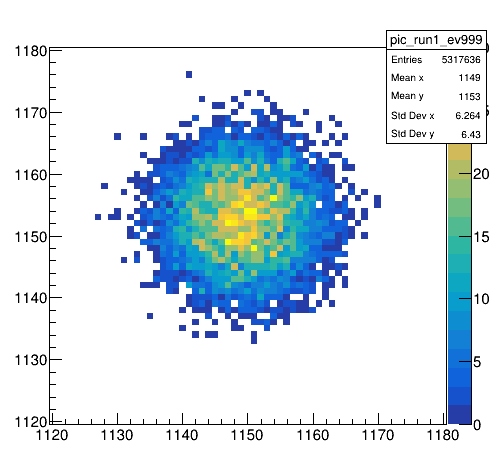

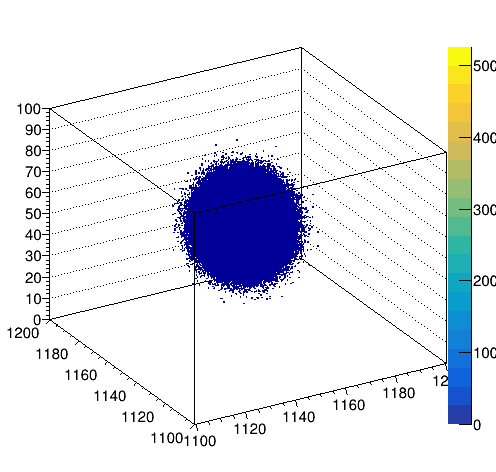

In [73]:
rt.gStyle.SetCanvasPreferGL(1);

## create final image
final_image=rt.TH2I('pic_run1_ev'+str(iev), '', x_pix, 0, x_pix-1, y_pix, 0, y_pix-1)
print("created final_image")
final_image=rn.array2hist(array2d_Nph, final_image)
    
c = rt.TCanvas("c","",500,500)
final_image.GetXaxis().SetRangeUser(1120,1180)
final_image.GetYaxis().SetRangeUser(1120,1180)

final_image.Draw("colz")
c.Draw()

c2 = rt.TCanvas("c2","",500,500)
histo_cloud.GetXaxis().SetRangeUser(1100,1200)
histo_cloud.GetYaxis().SetRangeUser(1100,1200)
histo_cloud.GetZaxis().SetRangeUser(0,100)
hX = histo_cloud.ProjectionX()

histo_cloud.Draw("box2z")
#hX.Draw()
c2.Draw()

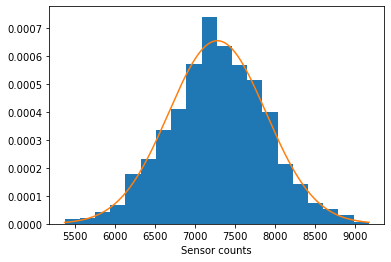

mean = 7282, sigma = 608, resolution = 0.083544


In [74]:
  

#fig, ax = plt.subplots()
num_bins = 20

## the histogram of the data
##n, bins, patches = ax.hist(nph_array, num_bins, density=True)
plt.hist(nph_array, num_bins, density=True)

# best fit of data
m, s = stats.norm.fit(nph_array) # get mean and standard deviation  
xmin, xmax = min(nph_array), max(nph_array)  
lnspc = np.linspace(xmin, xmax, len(nph_array))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


## Tweak spacing to prevent clipping of ylabel
##fig.tight_layout()array2d_NelGEM3

plt.xlabel('Sensor counts')
plt.ylabel('')
plt.show()

print("mean = %d, sigma = %d, resolution = %f"%(m,s,s/m))



##print(nsec_1GEM_array)
#plt.hist(nsec_1GEM_array,num_bins, density=True)
##plt.xlim(xmin=0, xmax = 1000)
##plt.ylim(ymin=0, ymax = 10000)
#EXP = expon.fit(nsec_1GEM_array, floc=0)
#print(EXP)
#xmin, xmax = min(nsec_1GEM_array), max(nsec_1GEM_array)
#lnspc2 = np.linspace(0, 600, 100)
##print(lnspc2)
#pdf_exp = stats.expon.pdf(lnspc2,*EXP)
#plt.plot(lnspc2, pdf_exp, label="exp")

#plt.show()

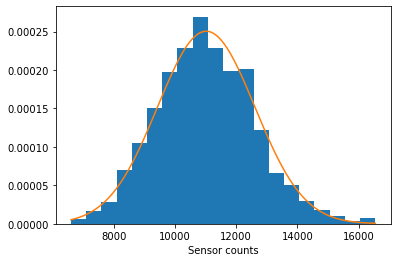

mean = 11016, sigma = 1592, resolution = 0.144569


In [75]:
#fig, ax = plt.subplots()
num_bins = 20

## the histogram of the data
##n, bins, patches = ax.hist(nph_array, num_bins, density=True)
plt.hist(nph_nosat, num_bins, density=True)

# best fit of data
m, s = stats.norm.fit(nph_nosat) # get mean and standard deviation  
xmin, xmax = min(nph_nosat), max(nph_nosat)  
lnspc = np.linspace(xmin, xmax, len(nph_nosat))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it


## Tweak spacing to prevent clipping of ylabel
##fig.tight_layout()array2d_NelGEM3

plt.xlabel('Sensor counts')
plt.ylabel('')
plt.show()

print("mean = %d, sigma = %d, resolution = %f"%(m,s,s/m))